---




## VARIATIONAL AUTOENCODER

---


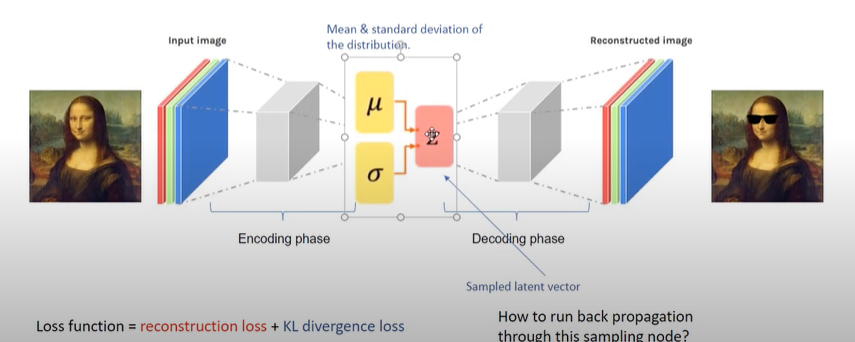

In [1]:
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape
#from keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
import tensorflow.compat.v1.keras.backend as K
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# Load MNIST
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [3]:
#Normalize and reshape ============

#Norm.
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train / 255
x_test = x_test / 255

In [4]:
# Reshape 
img_width  = x_train.shape[1]
img_height = x_train.shape[2]
num_channels = 1 #MNIST --> grey scale so 1 channel
x_train = x_train.reshape(x_train.shape[0], img_height, img_width, num_channels)
x_test = x_test.reshape(x_test.shape[0], img_height, img_width, num_channels)
input_shape = (img_height, img_width, num_channels)

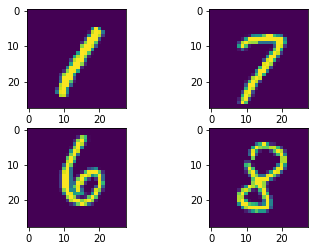

In [5]:
#View a few images
plt.figure(1)
plt.subplot(221)
plt.imshow(x_train[23][:,:,0])

plt.subplot(222)
plt.imshow(x_train[230][:,:,0])

plt.subplot(223)
plt.imshow(x_train[2300][:,:,0])

plt.subplot(224)
plt.imshow(x_train[32000][:,:,0])
plt.show()

In [6]:
# BUILD THE MODEL

# # ================= #############
# # Encoder
#Let us define 4 conv2D, flatten and then dense
# # ================= ############

latent_dim = 2 # Number of latent dim parameters

input_img = Input(shape=input_shape, name='encoder_input')
x1 = Conv2D(32, 3, padding='same', activation='relu')(input_img)
x2 = Conv2D(64, 3, padding='same', activation='relu',strides=(2, 2))(x1)
x3 = Conv2D(64, 3, padding='same', activation='relu')(x2)
x = Conv2D(64, 3, padding='same', activation='relu')(x3)

In [7]:
model=Model(input_img,x)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        36928     
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        36928     
                                                                 
Total params: 92,672
Trainable params: 92,672
Non-trainable params: 0
_________________________________________________________________


In [8]:
conv_shape = K.int_shape(x) #Shape of conv to be provided to decoder

In [9]:
print(conv_shape)

(None, 14, 14, 64)


In [10]:
#Flatten
x = Flatten()(x)
#x = Dense(32, activation='relu')(x)

In [11]:
# Two outputs, for latent mean and log variance (std. dev.)
#Use these to sample random variables in latent space to which inputs are mapped. 
z_mu = Dense(latent_dim, name='latent_mu')(x)   #Mean values of encoded input
z_sigma = Dense(latent_dim, name='latent_sigma')(x)  #Std dev. (variance) of encoded input


In [12]:
#REPARAMETERIZATION TRICK
# Define sampling function to sample from the distribution
# Reparameterize sample based on the process defined by Gunderson and Huang
# into the shape of: mu + sigma squared x eps
#This is to allow gradient descent to allow for gradient estimation accurately. 
def sample_z(args):
  z_mu, z_sigma = args
  eps = K.random_normal(shape=(K.shape(z_mu)[0], K.int_shape(z_mu)[1]))
  return z_mu + K.exp(z_sigma / 2) * eps

In [13]:
# sample vector from the latent distribution
# z is the lambda custom layer we are adding for gradient descent calculations
  # using mu and variance (sigma)
z = Lambda(sample_z, output_shape=(latent_dim, ), name='z')([z_mu, z_sigma])


In [14]:
#Z (lambda layer) will be the last layer in the encoder.
# Define and summarize encoder model.
encoder = Model(input_img, [z_mu, z_sigma, z], name='encoder')
print(encoder.summary())

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 28, 28, 32)   320         ['encoder_input[0][0]']          
                                                                                                  
 conv2d_1 (Conv2D)              (None, 14, 14, 64)   18496       ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 14, 14, 64)   36928       ['conv2d_1[0][0]']               
                                                                                            

In [15]:
# Decoder
# decoder takes the latent vector as input
decoder_input = Input(shape=(latent_dim, ), name='decoder_input')

# Need to start with a shape that can be remapped to original image shape as
#we want our final output to be same shape original input.
#So, add dense layer with dimensions that can be reshaped to desired output shape
x = Dense(conv_shape[1]*conv_shape[2]*conv_shape[3], activation='relu')(decoder_input)
# reshape to the shape of last conv. layer in the encoder, so we can 
x = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x)
# upscale (conv2D transpose) back to original shape
# use Conv2DTranspose to reverse the conv layers defined in the encoder
x = Conv2DTranspose(32, 3, padding='same', activation='relu',strides=(2, 2))(x)
#Can add more conv2DTranspose layers, if desired. 
#Using sigmoid activation
x = Conv2DTranspose(num_channels, 3, padding='same', activation='sigmoid', name='decoder_output')(x)


In [16]:
print(conv_shape[2])

14


In [17]:
# Define and summarize decoder model
decoder = Model(decoder_input, x, name='decoder')
decoder.summary()

# apply the decoder to the latent sample 
z_decoded = decoder(z)


Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 12544)             37632     
                                                                 
 reshape (Reshape)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 28, 28, 32)       18464     
 nspose)                                                         
                                                                 
 decoder_output (Conv2DTrans  (None, 28, 28, 1)        289       
 pose)                                                           
                                                                 
Total params: 56,385
Trainable params: 56,385
Non-trainable

In [18]:
#Define custom loss
#VAE is trained using two loss functions reconstruction loss and KL divergence
#Let us add a class to define a custom layer with loss
class CustomLayer(keras.layers.Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        
        # Reconstruction loss (as we used sigmoid activation we can use binarycrossentropy)
        recon_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        
        # KL divergence
        kl_loss = -5e-4 * K.mean(1 + z_sigma - K.square(z_mu) - K.exp(z_sigma), axis=-1)
        return K.mean(recon_loss + kl_loss)

    # add custom loss to the class
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x

# apply the custom loss to the input images and the decoded latent distribution sample
y = CustomLayer()([input_img, z_decoded])
# y is basically the original image after encoding input img to mu, sigma, z
# and decoding sampled z values.
#This will be used as output for vae

In [19]:
# VAE 
# =================
vae = Model(input_img, y, name='vae')

# Compile VAE
vae.compile(optimizer='adam', loss=None)
vae.summary()

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 28, 28, 32)   320         ['encoder_input[0][0]']          
                                                                                                  
 conv2d_1 (Conv2D)              (None, 14, 14, 64)   18496       ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 14, 14, 64)   36928       ['conv2d_1[0][0]']               
                                                                                                

In [20]:
# Train autoencoder
vae.fit(x_train, None, epochs = 10, batch_size = 32, validation_split = 0.2)

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
47744/48000 [============================>.] - ETA: 0s - loss: 0.2274

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


48000/48000 [==============================] - 27s 555us/sample - loss: 0.2273 - val_loss: 0.2088
Epoch 2/10
48000/48000 [==============================] - 8s 166us/sample - loss: 0.2018 - val_loss: 0.1963
Epoch 3/10
48000/48000 [==============================] - 8s 167us/sample - loss: 0.1949 - val_loss: 0.1925
Epoch 4/10
48000/48000 [==============================] - 8s 168us/sample - loss: 0.1915 - val_loss: 0.1896
Epoch 5/10
48000/48000 [==============================] - 8s 168us/sample - loss: 0.1892 - val_loss: 0.1883
Epoch 6/10
48000/48000 [==============================] - 9s 185us/sample - loss: 0.1875 - val_loss: 0.1867
Epoch 7/10
48000/48000 [==============================] - 8s 168us/sample - loss: 0.1862 - val_loss: 0.1863
Epoch 8/10
48000/48000 [==============================] - 8s 168us/sample - loss: 0.1852 - val_loss: 0.1859
Epoch 9/10
48000/48000 [==============================] - 8s 167us/sample - loss: 0.1843 - val_loss: 0.1847
Epoch 10/10
48000/48000 [=============

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


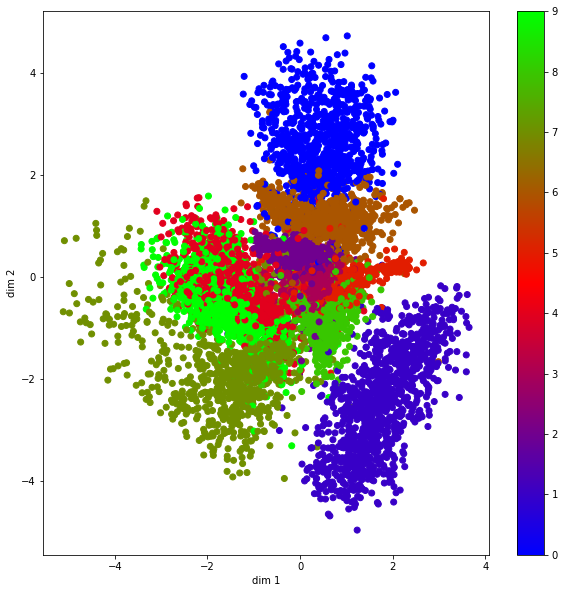

In [21]:
# Visualize results
# =================
#Visualize inputs mapped to the Latent space
#Remember that we have encoded inputs to latent space dimension = 2. 
#Extract z_mu --> first parameter in the result of encoder prediction representing mean

mu, _, _ = encoder.predict(x_test)
#Plot dim1 and dim2 for mu
plt.figure(figsize=(10, 10))
plt.scatter(mu[:, 0], mu[:, 1], c=y_test, cmap='brg')
plt.xlabel('dim 1')
plt.ylabel('dim 2')
plt.colorbar()
plt.show()


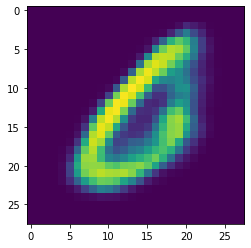

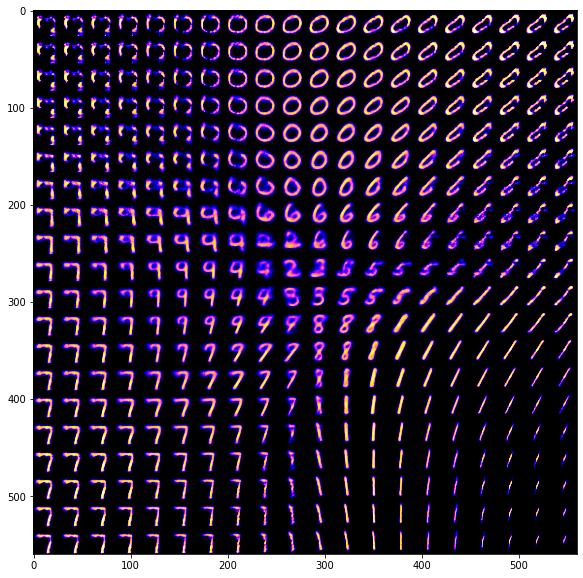

In [26]:
# Visualize images
#Single decoded image with random input latent vector (of size 1x2)
#Latent space range is about -5 to 5 so pick random values within this range
#Try starting with -1, 1 and slowly go up to -1.5,1.5 and see how it morphs from 
#one image to the other.
sample_vector = np.array([[1.5,1.8]])
decoded_example = decoder.predict(sample_vector)
decoded_example_reshaped = decoded_example.reshape(img_width, img_height)
plt.imshow(decoded_example_reshaped)

#Let us automate this process by generating multiple images and plotting
#Use decoder to generate images by tweaking latent variables from the latent space
#Create a grid of defined size with zeros. 
#Take sample from some defined linear space. In this example range [-4, 4]
#Feed it to the decoder and update zeros in the figure with output.


n = 20  # generate 15x15 digits
figure = np.zeros((img_width * n, img_height * n, num_channels))

#Create a Grid of latent variables, to be provided as inputs to decoder.predict
#Creating vectors within range -5 to 5 as that seems to be the range in latent space
grid_x = np.linspace(-5, 5, n)
grid_y = np.linspace(-5, 5, n)[::-1]

# decoder for each square in the grid
for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(img_width, img_height, num_channels)
        figure[i * img_width: (i + 1) * img_width,
               j * img_height: (j + 1) * img_height] = digit

plt.figure(figsize=(10, 10))
#Reshape for visualization
fig_shape = np.shape(figure)
figure = figure.reshape((fig_shape[0], fig_shape[1]))

plt.imshow(figure, cmap='gnuplot2')
plt.show()  
